# Georgia
We will be analyzing the congressional district maps in Georgia followwing the 2020 census. Currently Georgia's congressional map is in litigation so we want to examine how that could have effected the 2024 U.S. House election. We will be looking at their 2021 plan which was used for the 2022 election and then a new 2023 plan which was used in the 2024 election. The 2023 plan was a placeholder to fix some of the issues with the 2021 so the 2024 election would have a less problematic map.

## Import Required Packages

In [1]:
# For working with graphs
import networkx as nx

# For making plots
import matplotlib.pyplot as plt
import numpy as np

# Needed for gerrychain
import gerrychain   
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, GeographicPartition
from gerrychain.updaters import cut_edges, Tally
from gerrychain.tree import recursive_tree_part
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import geopandas as gpd
import pandas as pd

# Other necessary packages
import random
import maup

## Analysis of maps by senate voting

Now that we have set up the data, we can start our analysis!

We want to determine what party would have won the election for the U.S. House of Representative in each district for each of the two maps we have for Georgia. However, instead of using House candidates, we will be using U.S. Senate candidates because those were elected across the whole state. Thus, we will be using the Senate election as a placeholder for the House election because in the next party, once we move the congressional district boundary using a random walk, the candidates for the House would change. We are assuming voters would vote by party so we will use a statewide election where there were two candidates, one from each party, to determine how each voters would vote in a new House election.

In [2]:
# Read in our saved data frame
ga_data_gdf = gpd.read_file("save-new-data/GA-election-census-data-by-precincts.shp")

In [3]:
# Read in our 2021 and 2023 congressional district gdp for district boundaries
ga_2023_gdf = gpd.read_file("congress-2023-shape/Congress-2023-shape.shp")
ga_2021_gdf = gpd.read_file("congress-prop1-2021-shape/CONGRESS-PROP1-2021-shape.shp")

### 2021 Congressional Map

We will use the U.S. Senate election to see what party the candidate for the U.S. House would have been elected from based on the 2021 congressional districting map. In 2022, there were three candidates that ran for the U.S. Senate: Democrat Raphael Warnock (G22USSDWAR), Libertarian Chase Oliver (G22USSLOLI), and Republican Herschel Junior Walker (G22USSRWAL).

In [4]:
# Group by congressional district and calculate total votes for each candidate
district_totals = ga_data_gdf.groupby('DIST2021')[['G22USSDWAR', 'G22USSRWAL', 'G22USSLOLI']].sum()

# Determine the winning party in each district
district_totals['Winner-2021'] = np.where(
    (district_totals['G22USSDWAR'] > district_totals['G22USSRWAL']) & (district_totals['G22USSDWAR'] > district_totals['G22USSLOLI']),
    "Democrat",
    np.where(
        (district_totals['G22USSRWAL'] > district_totals['G22USSDWAR']) & (district_totals['G22USSRWAL'] > district_totals['G22USSLOLI']),
        "Republican",
        "Libertarian"
    )
)

# Reset index to turn District back into a column (optional)
district_totals_2021 = district_totals.reset_index()

print(district_totals_2021)

    DIST2021  G22USSDWAR  G22USSRWAL  G22USSLOLI Winner-2021
0          0      220417       43733        3767    Democrat
1          1      125967      171205        8839  Republican
2          2      252757       42830        4654    Democrat
3          3      222628       51792        4830    Democrat
4          4      147330       82227        5567    Democrat
5          5      137770      184973        9750  Republican
6          6      116632      185201        6720  Republican
7          7       86853      200997        7901  Republican
8          8      130612      108390        3083    Democrat
9          9      107586      197132        7368  Republican
10        10      112701      147908        4742  Republican
11        11       90283      168933        4098  Republican
12        12      113751      148997        3883  Republican
13        13       80830      174124        6163  Republican


In [5]:
# Count the number of districts won by each party
winner_summary_2021 = district_totals_2021['Winner-2021'].value_counts()

print(winner_summary_2021)

Winner-2021
Republican    9
Democrat      5
Name: count, dtype: int64


In [6]:
ga_data_gdf = ga_data_gdf.merge(district_totals_2021[["DIST2021", "Winner-2021"]], on='DIST2021', how='left')

<Axes: >

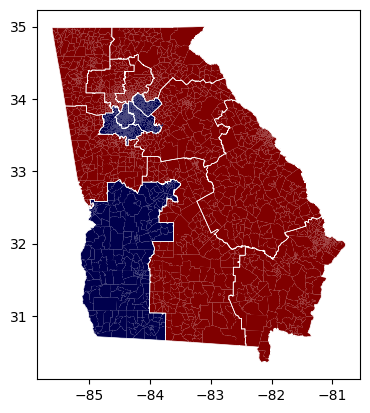

In [7]:
fig, ax = plt.subplots()

# Plot the units with the vote percentage as color
ga_data_gdf.plot(column = "Winner-2021", ax=ax, cmap = "seismic")

# Overlay districts
ga_2021_gdf.boundary.plot(ax=ax, color='white', linewidth=0.5)

### 2023 Congressional Map
We will use the U.S. Senate election to see what party the candidate for the U.S. House would have been elected from based on the 2023 congressional districting map. Since we are using the same senate election as above, the candidates in 2022 were the same: Democrat Raphael Warnock (G22USSDWAR), Libertarian Chase Oliver (G22USSLOLI), and Republican Herschel Junior Walker (G22USSRWAL).

In [8]:
# Group by congressional district and calculate total votes for each candidate
district_totals = ga_data_gdf.groupby('DIST2023')[['G22USSDWAR', 'G22USSRWAL', 'G22USSLOLI']].sum()

# Determine the winning party in each district
district_totals['Winner-2023'] = np.where(
    (district_totals['G22USSDWAR'] > district_totals['G22USSRWAL']) & (district_totals['G22USSDWAR'] > district_totals['G22USSLOLI']),
    "Democrat",
    np.where(
        (district_totals['G22USSRWAL'] > district_totals['G22USSDWAR']) & (district_totals['G22USSRWAL'] > district_totals['G22USSLOLI']),
        "Republican",
        "Libertarian"
    )
)

# Reset index to turn District back into a column (optional)
district_totals_2023 = district_totals.reset_index()

print(district_totals_2023)

    DIST2023  G22USSDWAR  G22USSRWAL  G22USSLOLI Winner-2023
0          0      130612      108390        3083    Democrat
1          1      107586      197132        7368  Republican
2          2      112701      147908        4742  Republican
3          3       90283      168933        4098  Republican
4          4      113751      148997        3883  Republican
5          5       85944      183778        6799  Republican
6          6      218517       64565        5109    Democrat
7          7      119764      185419        9520  Republican
8          8      245884       30067        4303    Democrat
9          9      189184       46249        4288    Democrat
10        10      195087       69989        4836    Democrat
11        11      126653      189123        9249  Republican
12        12       90555      186902        7561  Republican
13        13      119596      180990        6526  Republican


In [9]:
# Count the number of districts won by each party
winner_summary_2023 = district_totals_2023['Winner-2023'].value_counts()

print(winner_summary_2023)

Winner-2023
Republican    9
Democrat      5
Name: count, dtype: int64


In [10]:
ga_data_gdf = ga_data_gdf.merge(district_totals_2023[["DIST2023", "Winner-2023"]], on='DIST2023', how='left')

<Axes: >

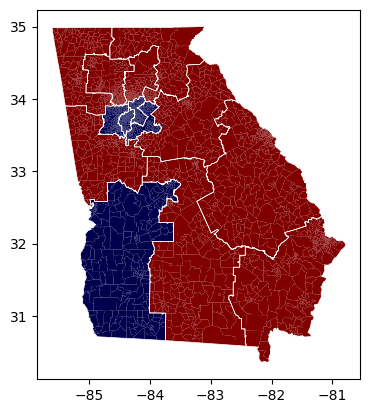

In [11]:
fig, ax = plt.subplots()

# Plot the units with the vote percentage as color
ga_data_gdf.plot(column = "Winner-2023", ax=ax, cmap = "seismic")

# Overlay districts
ga_2023_gdf.boundary.plot(ax=ax, color='white', linewidth=0.5)

### Setting up our Random Walk

In [12]:
ga_graph = Graph.from_file("save-new-data/GA-election-census-data-by-precincts.shp")

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/gerrychain/graph/graph.py:266: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/gerrychain/graph/graph.py:457: UserWarning: NA values found in column P1_001N!
  warnings.warn("NA values found in column {}!".format(column))
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/gerrychain/graph/graph.py:457: UserWarning: NA values found in column P1_002N!
  warnings.warn("NA values found in column {}!".format(column))
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/gerrychain/graph/graph.py:457: UserWarning: NA values found in column P1_003N!
  warnings.warn("NA values found in column {}!".format(column))
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-p

In [ ]:
ga_graph.columns

In [ ]:
# Make an initial districting plan

num_dist = 13 # Number of Congressional Districts in NC
tot_pop = sum([ga_graph.nodes()[v]['TOTPOP'] for v in ga_graph.nodes()])
ideal_pop = tot_pop/num_dist
pop_tolerance = 0.02
initial_plan = recursive_tree_part(ga_graph, range(num_dist), ideal_pop, 'TOTPOP', pop_tolerance, 10)

 ## Set up random walk

 Examining black population and 2016 presidential election vote.

In [ ]:
#Set up partition object
initial_partition = Partition(
    nc_graph, # dual graph
    assignment = initial_plan, # initial districting plan
    updaters = { 
        "district population": Tally("TOTPOP", alias = "district population"), 
        "district BPOP": Tally("NH_BLACK", alias = "district BPOP"),
        "R Votes": Tally("EL16G_PR_R", alias = "R Votes"), 
        "D Votes": Tally("EL16G_PR_D", alias = "D Votes")
    }
) 

 ### Decide how to make a step in the random walk

In [ ]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

 Contraint on population: stay within pop_tolerance of ideal

In [ ]:
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key = "district population"
    )

### Creating the chain

In [ ]:
our_random_walk = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # accepts every proposed plan that meets population criteria
    initial_state = initial_partition, 
    total_steps = 10000
)

In [ ]:
bmaj_ensemble = []
d_ensemble = [] 
bpop = [] 

for current_plan in our_random_walk:    
    # Calculate number of black-majority districts 
    # Add to ensemble
    num_maj_black = 0
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/current_plan["district population"][i]
        if b_perc >= 0.37:
            num_maj_black += 1
    bmaj_ensemble.append(num_maj_black)

    # Calculate number of districts with more Democratic votes than Republican votes
    d = 0
    for i in range(num_dist):
        if current_plan["R Votes"][i] < current_plan["D Votes"][i]: 
            d = d + 1
    d_ensemble.append(d)

    # Calculate the percentage of black population for each district at each step
    bpop_this_step = []
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/ current_plan["district population"][i]
        bpop_this_step.append(b_perc)
    bpop_this_step.sort()
    bpop.append(bpop_this_step)

bpop_rand = np.array(bpop)